In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mpi4py import MPI
import socket

In [3]:
df = pd.read_csv('data/asteroid-dataset.csv')
df, df_test = train_test_split(df, test_size=0.2, random_state=42)

/tmp/ipykernel_4053/1714289756.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/asteroid-dataset.csv')


<H1 style="color:Red">Columns Analysis</H1>

In [4]:
#get numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns;

In [5]:
df[numeric_columns];

In [6]:
df.columns

Index(['id', 'spkid', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'H',
       'diameter', 'albedo', 'diameter_sigma', 'orbit_id', 'epoch',
       'epoch_mjd', 'epoch_cal', 'equinox', 'e', 'a', 'q', 'i', 'om', 'w',
       'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'moid_ld',
       'sigma_e', 'sigma_a', 'sigma_q', 'sigma_i', 'sigma_om', 'sigma_w',
       'sigma_ma', 'sigma_ad', 'sigma_n', 'sigma_tp', 'sigma_per', 'class',
       'rms'],
      dtype='object')

<H2 style="color:Red">non numeric columns analysis</H2>

In [7]:
non_numeric_columns = df.select_dtypes(exclude='number').columns
non_numeric_columns

Index(['id', 'full_name', 'pdes', 'name', 'prefix', 'neo', 'pha', 'orbit_id',
       'equinox', 'class'],
      dtype='object')

In [8]:
nunique_cat_series = df[non_numeric_columns].nunique().sort_values(ascending=False)
discard_cat_columns = nunique_cat_series[(nunique_cat_series < 2) | (nunique_cat_series > 100)]
discard_cat_columns

id           766819
full_name    766819
pdes         766819
name          17661
orbit_id       3904
prefix            1
equinox           1
dtype: int64

Columns were discarded because they have too many unique values for a categorical column, or only one value.

In [9]:
# df[non_numeric_columns]['class'].value_counts()

<H3 style="color:Red">Convert Target column to numeric</H3>

In [10]:
df['pha'].value_counts()

pha
N    749330
Y      1643
Name: count, dtype: int64

In [11]:
df['pha'] = df['pha'].map({'N': 0, 'Y': 1})
df['pha'] = df['pha'].fillna(-1)  #drop later these values


In [12]:
df['pha'].value_counts()

pha
 0.0    749330
-1.0     15846
 1.0      1643
Name: count, dtype: int64

In [13]:
numeric_columns.append('pha')

<H2 style="color:Red">Identify importance of features</H2>

<H4 style="color:Red">Correlation analysis</H4>

In [14]:
df[numeric_columns].corr()['pha'].sort_values()

H                -0.034506
moid             -0.030113
diameter         -0.019826
diameter_sigma   -0.016068
spkid            -0.011536
ma               -0.008824
q                -0.002147
sigma_e          -0.000363
sigma_q          -0.000329
sigma_i          -0.000283
sigma_n          -0.000186
sigma_om         -0.000164
sigma_a          -0.000158
sigma_per        -0.000137
sigma_ad         -0.000135
sigma_w          -0.000074
sigma_ma         -0.000074
sigma_tp         -0.000073
per_y             0.000350
per               0.000350
a                 0.000491
om                0.001165
ad                0.001258
w                 0.001695
tp                0.003641
tp_cal            0.003677
i                 0.003927
rms               0.012657
epoch_cal         0.014871
epoch             0.016908
epoch_mjd         0.016908
albedo            0.018955
n                 0.055065
e                 0.060528
moid_ld           0.079452
pha               1.000000
Name: pha, dtype: float64

<H4 style="color:Red">Chi Square Analysis</H4>

In [15]:
from sklearn.feature_selection import r_regression

In [16]:
df = df.loc[df['pha'] != -1]

X = df[numeric_columns].drop(columns=['pha'])
y = df['pha']


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_temp = X_train.fillna(X_train.mean())

In [17]:
# Define o filtro para selecionar colunas onde o valor mínimo é maior ou igual a 0
mask_min = X_train_temp.describe().T['min'] >= 0

# Aplica a máscara ao dataframe para retornar apenas as colunas correspondentes
X_train_temp = X_train_temp.loc[:, mask_min]


In [18]:
r_value = r_regression(X_train_temp, y_train)

In [19]:
r_value = pd.Series(r_value, index=X_train_temp.columns)


In [20]:
discard_num_columns = r_value[(r_value.abs() < 0.01)]
discard_num_columns;

In [21]:
df = pd.read_csv('data/asteroid-dataset.csv')
try:
    df.drop(columns=discard_num_columns.index, inplace=True)
    df.drop(columns=discard_cat_columns.index, inplace=True)
except Exception as e:
    print(e)

/tmp/ipykernel_4053/1420708325.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/asteroid-dataset.csv')


In [22]:
df['neo'] = df['neo'].map({'N': 0, 'Y': 1})
df['pha'] = df['pha'].map({'N': 0, 'Y': 1})
df

,neo,pha,H,e,a,q,i,ma,n,moid,moid_ld,class
0,0.0,0.0,3.400,0.076009,2.769165,2.558684,10.594067,77.372098,0.213885,1.594780,620.640533,MBA
1,0.0,0.0,4.200,0.229972,2.773841,2.135935,34.832932,144.975675,0.213345,1.234290,480.348639,MBA
2,0.0,0.0,5.330,0.256936,2.668285,1.982706,12.991043,125.435355,0.226129,1.034290,402.514639,MBA
3,0.0,0.0,3.000,0.088721,2.361418,2.151909,7.141771,95.861938,0.271609,1.139480,443.451432,MBA
4,0.0,0.0,6.900,0.190913,2.574037,2.082619,5.367427,17.846343,0.238661,1.095750,426.433027,MBA
...,...,...,...,...,...,...,...,...,...,...,...,...
958519,0.0,0.0,17.135,0.185919,2.280861,1.856807,5.984416,342.057565,0.286125,0.861979,335.456367,MBA
958520,0.0,0.0,18.500,0.282920,2.334910,1.674319,8.082280,260.113042,0.276248,0.671242,261.227249,MBA
958521,1.0,1.0,20.400,0.662446,2.817152,0.950941,4.679278,240.473601,0.208444,0.035589,13.850093,APO
958522,0.0,0.0,18.071,0.202053,2.373137,1.893638,0.732484,355.351127,0.269600,0.893896,347.877506,MBA


In [23]:
df.isnull().sum().sort_values(ascending=False).head()

pha        19921
moid       19921
H           6263
moid_ld      127
neo            4
dtype: int64

In [24]:
df = df.dropna()
df.drop(columns=['moid_ld', 'q'], inplace=True)

/tmp/ipykernel_4053/113574734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['moid_ld', 'q'], inplace=True)


In [25]:
df_num = df.select_dtypes(include=[np.number])

In [26]:
X = df.drop(columns=['pha'])
y = df['pha']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
hazard = tr.create_pipeline(X_train, y_train, LGBMClassifier(**ri.params_dict['LightGBM_2']))
hazard.fit(X_train, y_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['neo', 'H', 'e', 'a', 'i',
                                                   'ma', 'n', 'moid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['class'])],
                                   verbose_feature_names_out=Fals...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=880,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [28]:
X_train_tr = hazard[:-3].transform(X_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


<Axes: >

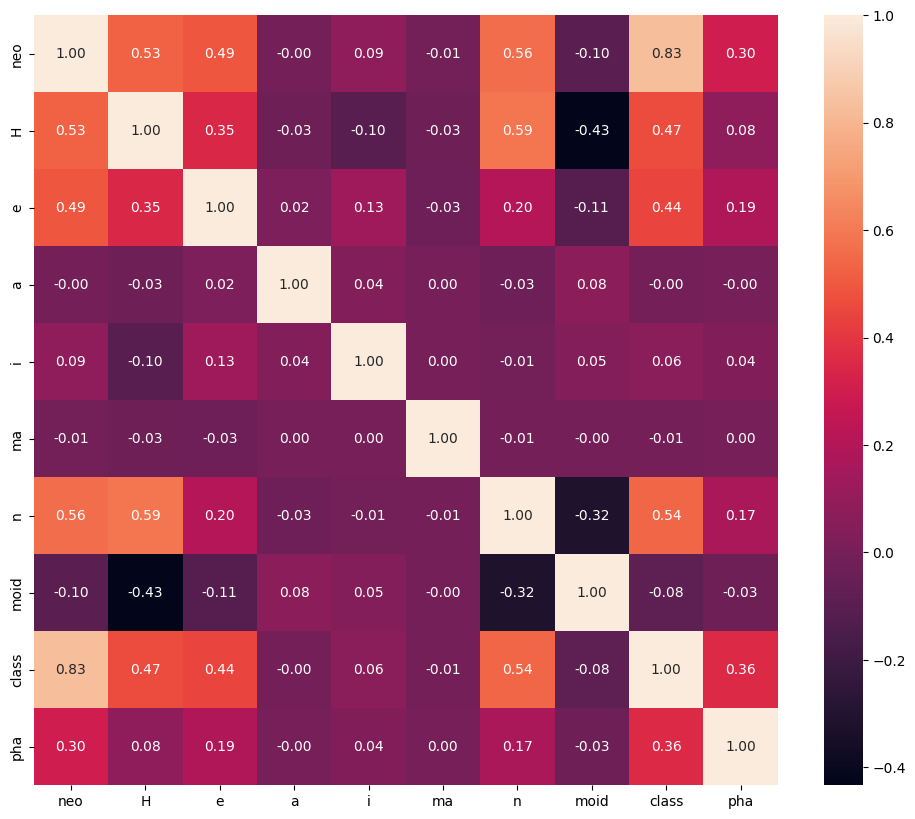

In [29]:
corr = pd.concat([X_train_tr, y_train], axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, fmt=".2f")

In [30]:
y_pred = hazard.predict(X_val)
ri.get_metrics_RI({'haz': hazard}, X_val, y_val, threshold_type='default')

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed i

,haz
Overall AUC,0.993934
KS,0.984849
Balanced Accuracy,0.989360
Accuracy,0.988116
Precision,0.160213
Recall,0.990610
F1,0.275817


Accuracy of the model is:  0.9881159233755926


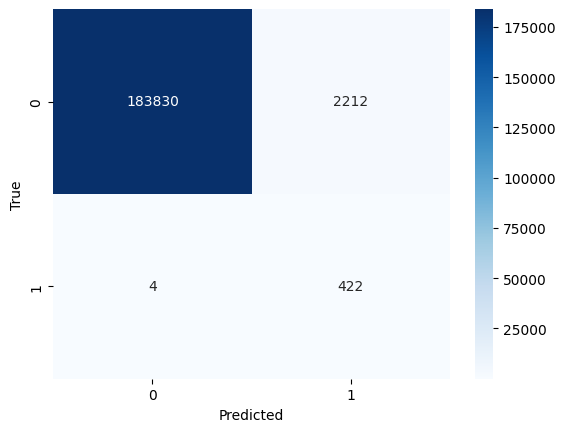

In [31]:
ev.plot_confusion_matrix(y_val, y_pred)

In [32]:
X_val["class"].unique()

array(['MBA', 'APO', 'IMB', 'AMO', 'TJN', 'OMB', 'TNO', 'ATE', 'MCA',
       'CEN', 'AST', 'IEO'], dtype=object)

In [33]:
for c in X_train['class'].unique():
    class_filter_train = X_train["class"] == c
    class_filter_val = X_val["class"] == c
    X_class_val = X_val[class_filter_val]
    X_class_train = X_train[class_filter_train]
    y_class_val = y_val[class_filter_val]
    y_class_train = y_train[class_filter_train]
    print(f"Class: {c} == {round(y_class_train.mean(),3)} in {len(y_class_train)} samples")

Class: MBA == 0.0 in 666072 samples
Class: IMB == 0.0 in 15729 samples
Class: MCA == 0.0 in 14268 samples
Class: APO == 0.139 in 10130 samples
Class: OMB == 0.0 in 21715 samples
Class: TJN == 0.0 in 6520 samples
Class: AMO == 0.014 in 6798 samples
Class: TNO == 0.0 in 2774 samples
Class: ATE == 0.096 in 1381 samples
Class: CEN == 0.0 in 418 samples
Class: AST == 0.0 in 46 samples
Class: IEO == 0.294 in 17 samples


In [34]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
train.shape, val.shape

((745868, 10), (186468, 10))

In [35]:
classes_to_drop = train.groupby('class')['pha'].sum()[lambda x: x == 0].index

# Filter out rows where the class is in the identified list
train_filtered = train[~train['class'].isin(classes_to_drop)]
val_filtered = val[~val['class'].isin(classes_to_drop)]

X_train = train_filtered.drop(columns='pha')
y_train = train_filtered['pha']
X_val = val_filtered.drop(columns='pha')
y_val = val_filtered['pha']

In [36]:
class_dict = {}

for c in X_train['class'].unique():
    print(f"Class: {c}")
    class_filter_train = X_train["class"] == c
    
    class_dict[c] = pd.concat([X_train[class_filter_train], y_train[class_filter_train]], axis=1)


Class: APO
Class: AMO
Class: ATE
Class: IEO


In [37]:
hazard = tr.create_pipeline(X_train, y_train, LGBMClassifier(**ri.params_dict['LightGBM_2']))
hazard.fit(X_train, y_train)

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['neo', 'H', 'e', 'a', 'i',
                                                   'ma', 'n', 'moid']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['class'])],
                                   verbose_feature_names_out=Fals...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=880,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [38]:
ri.get_metrics_RI({'haz': hazard}, X_val, y_val, threshold_type='default')

/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


,haz
Overall AUC,0.998372
KS,0.989253
Balanced Accuracy,0.994627
Accuracy,0.994075
Precision,0.944321
Recall,0.995305
F1,0.969143


Accuracy of the model is:  0.9940750493745886


/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_ave = X_copy.replace(mean)
/home/athyrson/miniconda3/envs/hpc/lib/python3.13/site-packages/credit_pipeline/training.py:116: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group_count = X_copy.replace(count)


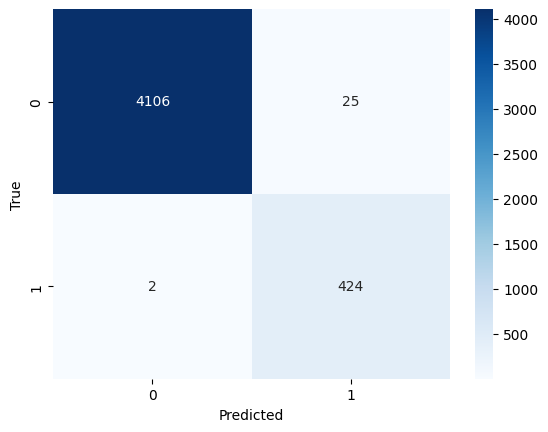

In [39]:
y_pred = hazard.predict(X_val)
ev.plot_confusion_matrix(y_val, y_pred)

In [45]:
train = pd.concat([X_val, y_val], axis=1)
val = pd.concat([X_train, y_train], axis=1)
df = pd.concat([train, val])
df.to_csv('data/pha-asteroids.csv', index=True)